In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loss_simulator import error_prob_model
import sys
sys.path.insert(0, '..')
from selective import SelectiveClassifier, LTTSelectiveClassifier, SelectiveClassifierStabilityEstimator

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 11

# Risk Distribution Comparison

This notebook compares the distribution of realized risks across three selective classification methods:
- **CRC-C**: Conservative Conformal Risk Control (targets α - β)
- **CRC**: Standard Conformal Risk Control (targets α)
- **LTT**: Learn Then Test (binomial-based RCPS method)

In [2]:
# Parameters
seed = 42 # fix seed for reproducibility
n_trials = 100  # number of trials
n_cal = 50  # calibration set size
n_test = 1000  # test set size
alpha = 0.1  # target risk
delta = 0.1 # confidence level for LTT
instability_param = 0.3  # instability level
base_strength = 10

print(f"Running {n_trials} trials...")
print(f"Calibration size: {n_cal}")
print(f"Test size: {n_test}")
print(f"Target α: {alpha}")
print(f"Instability ε: {instability_param}\\n")

# Store results
risks_crc_c = []
risks_crc = []
risks_ltt = []

Running 100 trials...
Calibration size: 50
Test size: 1000
Target α: 0.1
Instability ε: 0.3\n


In [ ]:
np.random.seed(seed=seed)

# Estimate beta once for efficiency
P_cal_beta = np.random.uniform(0, 1, n_cal)
error_prob_cal_beta = error_prob_model(P_cal_beta, alpha, base_strength, instability_param)
E_cal_beta = np.random.binomial(1, error_prob_cal_beta)

estimator = SelectiveClassifierStabilityEstimator(alpha=alpha, n_bootstrap=100)
beta_hat = estimator.estimate_beta_df(P_cal_beta, E_cal_beta)
alpha_conservative = max(0.01, alpha - beta_hat)
print(f"Estimated β̂ = {beta_hat:.4f}")
print(f"Conservative α' = {alpha_conservative:.4f}\n")

# Reset seed for trials
np.random.seed(seed=seed)

for trial in range(n_trials):
    if (trial + 1) % 50 == 0:
        print(f"  Completed {trial + 1}/{n_trials} trials...")
    
    # Generate calibration data
    P_cal = np.random.uniform(0, 1, n_cal)
    error_prob_cal = error_prob_model(P_cal, alpha, base_strength, instability_param)
    E_cal = np.random.binomial(1, error_prob_cal)
    
    # Generate test data
    P_test = np.random.uniform(0, 1, n_test)
    error_prob_test = error_prob_model(P_test, alpha, base_strength, instability_param)
    E_test = np.random.binomial(1, error_prob_test)
    
    # CRC-C method (conservative)
    classifier_c = SelectiveClassifier(alpha=alpha_conservative)
    theta_crc_c = classifier_c.fit(P_cal, E_cal)
    selected_crc_c = P_test > theta_crc_c
    if selected_crc_c.sum() > 0:
        risk_crc_c = E_test[selected_crc_c].mean()
    else:
        risk_crc_c = 0.0
    risks_crc_c.append(risk_crc_c)
    
    # CRC method (standard)
    classifier = SelectiveClassifier(alpha=alpha)
    theta_crc = classifier.fit(P_cal, E_cal)
    selected_crc = P_test > theta_crc
    if selected_crc.sum() > 0:
        risk_crc = E_test[selected_crc].mean()
    else:
        risk_crc = 0.0
    risks_crc.append(risk_crc)
    
    # LTT method
    classifier_ltt = LTTSelectiveClassifier(alpha=alpha, delta=delta)
    theta_ltt = classifier_ltt.fit(P_cal, E_cal)
    selected_ltt = P_test > theta_ltt
    if selected_ltt.sum() > 0:
        risk_ltt = E_test[selected_ltt].mean()
    else:
        risk_ltt = 0.0
    risks_ltt.append(risk_ltt)

# Convert to arrays
risks_crc_c = np.array(risks_crc_c)
risks_crc = np.array(risks_crc)
risks_ltt = np.array(risks_ltt)

print(f"\n✓ Completed all {n_trials} trials!")

Estimated β̂ = 0.1246
Conservative α' = 0.0100

  Completed 50/100 trials...
  Completed 100/100 trials...

✓ Completed all 100 trials!


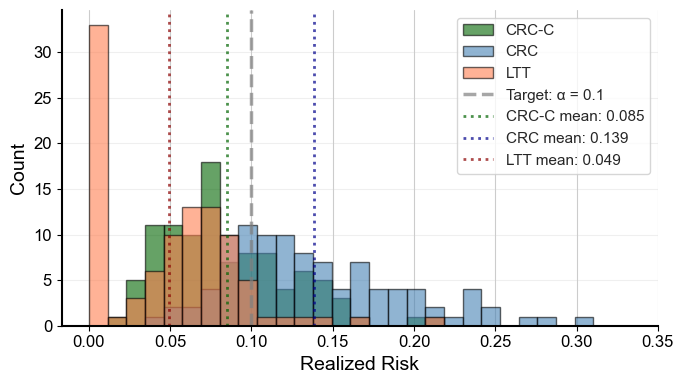


SUMMARY STATISTICS
Method          Mean Risk    Std        Violations  
------------------------------------------------------------
CRC-C           0.0847       0.0387     32/100
CRC             0.1386       0.0544     73/100
LTT             0.0490       0.0429     7/100


In [5]:
# Create histogram comparison
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Plot histograms with transparency (matching ImageNet notebook colors)
bins = np.linspace(0, max(risks_crc_c.max(), risks_crc.max(), risks_ltt.max()) * 1.1, 30)

ax.hist(risks_crc_c, bins=bins, alpha=0.6, label='CRC-C', color='darkgreen', edgecolor='black')
ax.hist(risks_crc, bins=bins, alpha=0.6, label='CRC', color='steelblue', edgecolor='black')
ax.hist(risks_ltt, bins=bins, alpha=0.6, label='LTT', color='coral', edgecolor='black')

# Add target line
ax.axvline(x=alpha, color='gray', linestyle='--', linewidth=2.5, 
           label=f'Target: α = {alpha}', alpha=0.7)

# Add mean lines
ax.axvline(x=risks_crc_c.mean(), color='darkgreen', linestyle=':', linewidth=2,
           label=f'CRC-C mean: {risks_crc_c.mean():.3f}', alpha=0.7)
ax.axvline(x=risks_crc.mean(), color='darkblue', linestyle=':', linewidth=2,
           label=f'CRC mean: {risks_crc.mean():.3f}', alpha=0.7)
ax.axvline(x=risks_ltt.mean(), color='darkred', linestyle=':', linewidth=2,
           label=f'LTT mean: {risks_ltt.mean():.3f}', alpha=0.7)

# Formatting
ax.set_xlabel('Realized Risk', fontsize=14, color='black')
ax.set_ylabel('Count', fontsize=14, color='black')
ax.legend(fontsize=11, loc='best', frameon=True)
ax.grid(True, alpha=0.3, axis='y')

# Ticks and spines
ax.tick_params(axis='x', colors='black', which='both', bottom=True, top=False)
ax.tick_params(axis='y', colors='black', which='both', left=True, right=False)
sns.despine(ax=ax, top=True, right=True)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_edgecolor('black')
    ax.spines[spine].set_linewidth(1.5)

plt.tight_layout()
plt.savefig('./outputs/risk_histogram_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"{'Method':<15} {'Mean Risk':<12} {'Std':<10} {'Violations':<12}")
print("-"*60)
print(f"{'CRC-C':<15} {risks_crc_c.mean():<12.4f} {risks_crc_c.std():<10.4f} {(risks_crc_c > alpha).sum()}/{n_trials}")
print(f"{'CRC':<15} {risks_crc.mean():<12.4f} {risks_crc.std():<10.4f} {(risks_crc > alpha).sum()}/{n_trials}")
print(f"{'LTT':<15} {risks_ltt.mean():<12.4f} {risks_ltt.std():<10.4f} {(risks_ltt > alpha).sum()}/{n_trials}")
print("="*60)